Задача: Проведите RFM анализ. В каждом подсегменте поделите пользователей на 4 класса

In [81]:
import pandas as pd
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [82]:
orders = pd.read_csv('RFM_ht_data.csv',sep=',', parse_dates=['InvoiceDate'],dtype={'InvoiceNo':'str','CustomerCode':'str'})

In [83]:
orders.head()

InvoiceNo CustomerCode InvoiceDate   Amount
0  C0011810010001     19067290  2020-09-01  1716.00
1  C0011810010017     13233933  2020-09-01  1489.74
2  C0011810010020     99057968  2020-09-01   151.47
3  C0011810010021     80007276  2020-09-01   146.72
4  C0011810010024     13164076  2020-09-01   104.00

In [84]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [85]:
#В качестве даты отсчета, будем использовать последнюю дату в датасете.
last_date = orders.InvoiceDate.max()

In [86]:
#Посчитаем для каждого пользователя его максимальный перерыв в совершении целевого действия, количество покупок и сумму всех заказов.
rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': 'count',      # Frequency #Количество заказов
                                        'Amount': 'sum'}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)


In [87]:
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [88]:
rfmSegmentation = rfmTable


In [90]:
#зададим пороги деления на классы для пользователей по квантилям соотвествующих распределений.
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [91]:
quantiles=rfmTable.quantile([0.25,0.5,0.75])

In [92]:
# Пороги деления на классы
quantiles

recency  frequency  monetary_value
0.25      2.0        1.0          765.00
0.50      8.0        2.0         1834.48
0.75     16.0        3.0         4008.84

In [93]:
#Найдем итоговый RFM-класс для каждого пользователя
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)                             + rfmSegmentation.F_Quartile.map(str)                             + rfmSegmentation.M_Quartile.map(str)

In [99]:
rfmSegmentation

recency  frequency  monetary_value  R_Quartile  F_Quartile  \
CustomerCode                                                               
02213019           19          1         1609.20           4           4   
02213042           22          3         9685.48           4           2   
02213071           29          1          415.00           4           4   
02213088           23          1          305.00           4           4   
02213092           25          1         1412.88           4           4   
...               ...        ...             ...         ...         ...   
99099927           10          1          961.10           3           4   
99099936            0          1         1521.78           1           4   
99099959            8          2         1444.56           2           3   
99099963           19          1         3018.91           4           4   
99099972            0          2         4577.37           1           3   

              M_Quartile RFMClass  
CustomerCode                       
02213019               3      443  
02213042               1      421  
02213071               4      444  
02213088               4      444  
02213092               3      443  
...                  ...      ...  
99099927               3      343  
99099936               3      143  
99099959               3      233  
99099963               2      442  
99099972               1      131  

[123733 rows x 7 columns]

In [102]:
#Посмотрим в каких сегментах у нас больше всего пользователей
rfmSegmentation.reset_index().groupby('RFMClass').agg({'CustomerCode':'count'}).sort_values('CustomerCode', ascending = False)

CustomerCode
RFMClass              
444              10624
111               9705
443               6729
344               6593
211               5847
...                ...
424                 63
214                 60
114                 60
314                 33
414                  2

[64 rows x 1 columns]

In [95]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)


F_Quartile      1     2     3      4
R_Quartile                          
1           14433  4671  5795   6074
2            9634  5889  8633  10399
3            3091  3748  7734  13263
4             542  1311  5415  23101

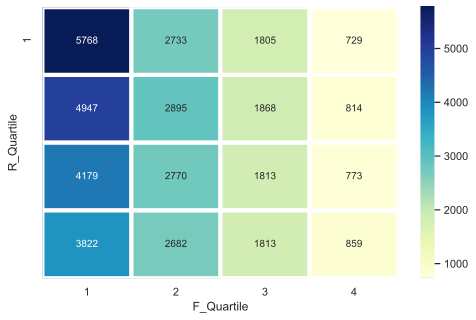

In [97]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

Теперь мы видим, какие пользователи давно не использовали наш поодукт, и которым мы можем, например, выслать персональное предложение для того, чтобы повлиять на их интерес к продукту, либо провести А/В тест.